# Code for 'Toxin Plasmids Affect Ecological Competition'

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
plt.rcParams.update({'mathtext.default': 'regular'})

import seaborn as sns

from scipy.integrate import solve_ivp
from scipy.stats import sem

import itertools as it

from SALib import ProblemSpec

from tqdm.notebook import tqdm

def m(X,k):
    '''
        Monod formular with half-saturation constant k.
        The maximum rate parameter is coded as a coefficient outside of the function.
    '''
    return X/(X+k)


def HGT_TOXIN(time, variables, *parameters):
    '''
        Defines the change in abundance of a community of cells
        competing with toxins over nutrients.
    '''
        
    A, B, C, N1, N2, T = variables
    
    b, fA, fB, k, KT, K1, K2, p, r, u = parameters
    
    dAdt  = (1-fA)*r*m(N1,K1)*A 
    
    dBdt  = (1-fB)*r*(p*m(N1,K1) + m(N2,K2))*B + b*(A + B)*C
    
    dCdt  = r*(p*m(N1,K1)+m(N2,K2))*C - k*m(T,KT)*C - b*(A + B)*C
       
    dN1dt = -m(N1,K1)*(A + p*(B + C))
    
    dN2dt = -m(N2,K2)*(B + C)
    
    dTdt  = fA*u*m(N1,K1)*A + fB*u*(p*m(N1,K1) + m(N2,K2))*B - m(T,KT)*C

    return dAdt, dBdt, dCdt, dN1dt, dN2dt, dTdt


def stop_condition(time, variables, *parameters):
    '''
        Integration is terminated when cell and nutrient concentrations have stabilised.
    '''

    A, B, C, N1, N2, T = variables

    dAdt, dBdt, dCdt, dN1dt, dN2dt, _ = HGT_TOXIN(time, variables, *parameters)
        
    tolerance = 10**-3

    return abs(dAdt) + abs(dBdt) + abs(dCdt) + abs(dN1dt) + abs(dN2dt) - tolerance


def integrate(model, ICs, params, maximum_time):
    '''
        Given a system of ODEs, returns the temporal dynamics.
    '''
        
    sol = solve_ivp(model, (0, maximum_time), list(ICs.values()),
                    args = list(params.values()),
                    events = stop_condition,
                    method = 'Radau' # opted for a stiff solver
                   )

    time = sol.t
    densities = np.transpose(sol.y)
    
    equilibriated = sol.status      # 0 if solver reached maximum_time
                                    # 1 if a termination event occurred
    
    ignore_stop = not stop_condition.terminal
    
    if equilibriated or ignore_stop:
        return time, densities
    
    else:
        raise Exception('Equilibrium not reached before maximum_time.')

        
def plot(time, densities, normalised=False, log_scaled=False):
    '''
        Plots the temporal dynamics, with options to
            (i) normalise the cell densities and/or 
            (ii) plot on a log-scaled y-axis.
    '''
    
    cells = densities[:,0:3]
    nutrients = densities[:,3:5]
    toxin = densities[:,5]
    
    fig, ax = plt.subplots(1,3, figsize = (9,2.5), constrained_layout = True)

    if normalised:
        cells /=  cells.sum(axis=1)[:,np.newaxis]

    if log_scaled:
        ax[0].set_yscale('log')
        ax[1].set_yscale('log')
        ax[2].set_yscale('log')
            
    ax[0].set_title('Cells')
    ax[1].set_title('Nutrients')
    ax[2].set_title('Toxins')

    ax[0].plot(time, cells)
    ax[1].plot(time, nutrients[:,0],'#d62728')
    ax[1].plot(time, nutrients[:,1],'#9467bd')

    ax[2].plot(time, toxin, 'k')

    ax[0].legend(['Donor (A)', 'Transconjugant (B)', 'Recipient (C)'])
    ax[1].legend(['Nutrient 1 \nCommunal', 'Nutrient 2 \nAdditional'])

#     plt.savefig(f"trajectories.svg", bbox_inches='tight')
    plt.show()    

# Do not change the ORDER of the elements in the following dictionaries.

ICs = {'A' : 10**-3,
       'B' : 0,
       'C' : 1,
       'N1': 1,
       'N2': 1,
       'T' : 0
      }

params = {'b' : 1,
          'fA': .5,
          'fB': .5, 
          'k' : 10,
          'KT': 10**-4, 
          'K1': 1,
          'K2': 1,
          'p' : .5,            
          'r' : 1,
          'u' : 100
         }

stop_condition.terminal = True # To ignore stop_condition and instead run to maximum_time set to False
maximum_time = 2000

#### Some example outputs of the model are shown below.

No Additional Nutrient and 1:1 Competition
Neither Toxin or Conjugation


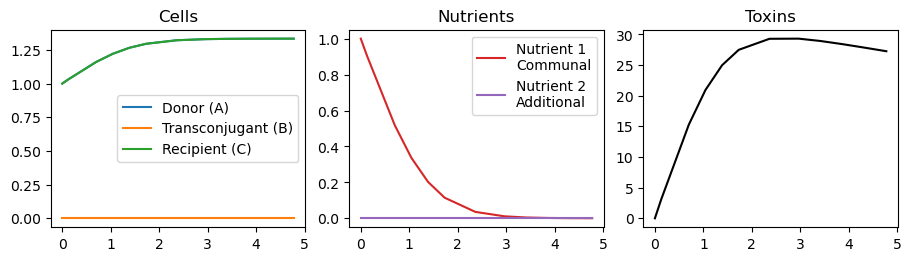

Toxin only


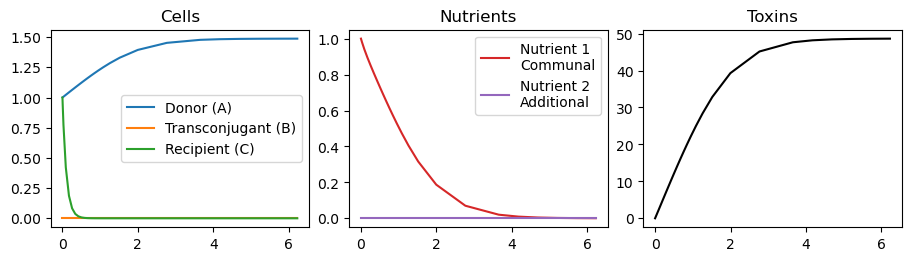

Conjugation only


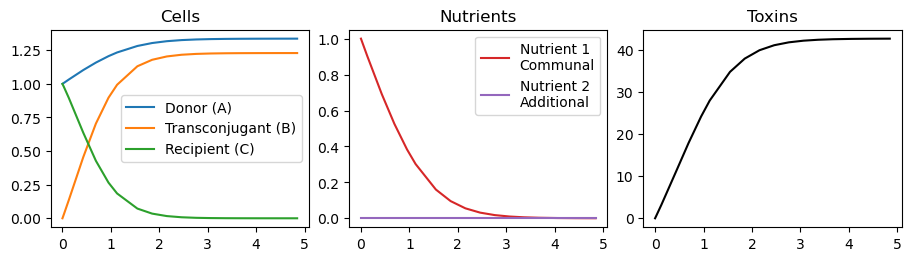

Toxin and Conjugation


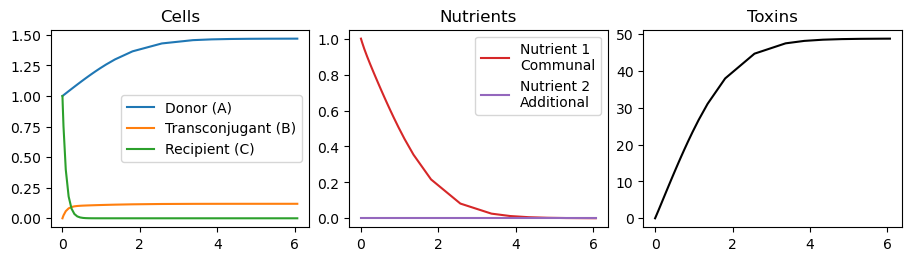

Additional Nutrient and Invasion
Neither Toxin or Conjugation


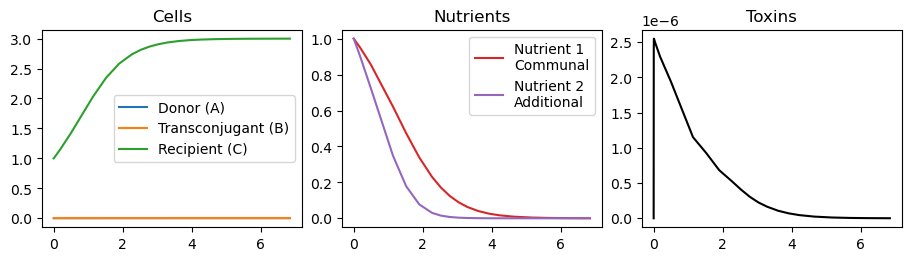

Toxin only


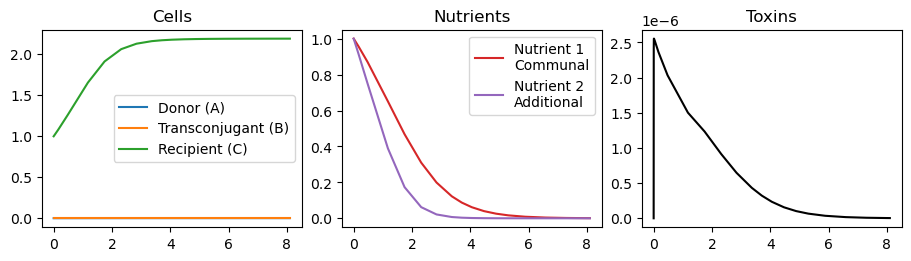

Conjugation only


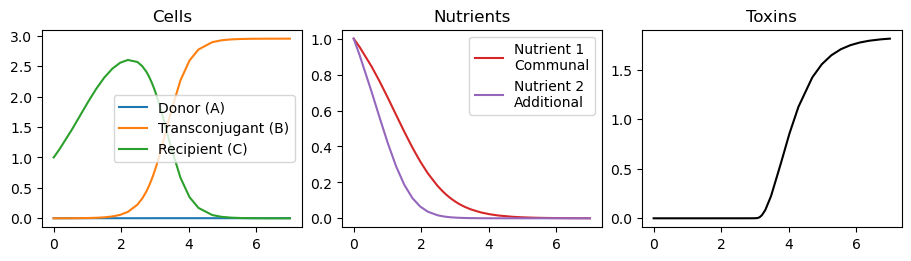

Toxin and Conjugation


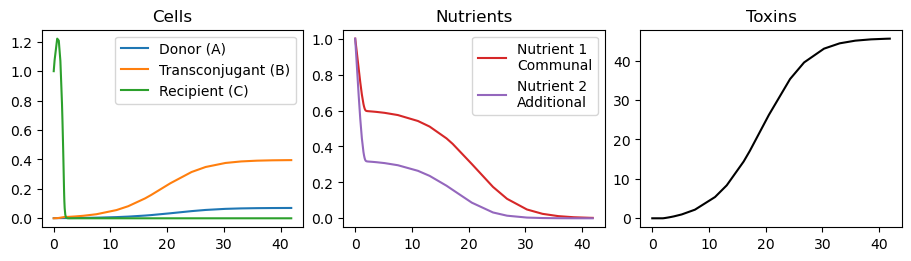

In [2]:
def run():    
    print('Neither Toxin or Conjugation')
    params['b'] = 0
    params['k'] = 0   
    time, densities = integrate(HGT_TOXIN, ICs, params, maximum_time)
    plot(time, densities)

    print('Toxin only')
    params['b'] = 0 
    params['k'] = 10
    time, densities = integrate(HGT_TOXIN, ICs, params, maximum_time)
    plot(time, densities)

    print('Conjugation only')
    params['b'] = 1 
    params['k'] = 0   
    time, densities = integrate(HGT_TOXIN, ICs, params, maximum_time)
    plot(time, densities)

    print('Toxin and Conjugation')
    params['b'] = 1
    params['k'] = 10
    time, densities = integrate(HGT_TOXIN, ICs, params, maximum_time)
    plot(time, densities)

print('No Additional Nutrient and 1:1 Competition')
ICs['N2'] = 0
ICs['A'] = 1
ICs['C'] = 1

run()

print('Additional Nutrient and Invasion')
ICs['N2'] = 1
ICs['A'] = 10**-3
ICs['C'] = 1

run()

# Sensitivity Analysis

#### Further reading
SaLib docs: https://salib.readthedocs.io

SaLib tutorial: https://waterprogramming.wordpress.com/2016/02/25/salib-v0-7-1-group-sampling-nonuniform-distributions

Sensitivity Analysis Tutorial: https://uc-ebook.org/docs/html/A2_Jupyter_Notebooks.html

----------------------------------------------------

Firstly, we need to propose distributions for each parameter we intend to study. SaLib allows for triangular, normal, lognormal and uniform distributions. The distributions are each controlled by two parameters (called `'bounds'` but not always bounds):

>* Triangular, `triang` (assumed lower bound of 0)
>    1. width of distribution (scale, must be greater than 0)
>    2. location of peak as a fraction of the scale (must be in [0,1])

>* Normal, `norm`
>    1. mean (location)
>    2. standard deviation (scale, must be greater than 0)

>* Lognormal($\mu, \sigma ^2$), `lognorm` (natural logarithms, assumed lower bound of 0)
>    1. ln-space mean (median/scale)
>    2. ln-space standard deviation (>0) (shape), variance changes in same direction  

>* Uniform, `unif`
>    1. lower bound
>    2. upper bound (must be greater than lower bound)

All the analysis information (in/out samples, results) are stored in a `ProblemSpec` object that I've call `SA_spec`.

In [3]:
def setup(conjugation=False):
    
    param_distributions = {}
    
    if conjugation:
        param_distributions.update({'b' : ['lognorm', [np.log(1), np.log(1.1)]]})
    else:
        params['b'] = 0
    
    param_distributions.update({'fA': ['triang',  [1, .5]],
                                'fB': ['triang',  [1, .5]], 
                                'k' : ['lognorm', [np.log(10), np.log(1.5)]],
                                'KT': ['lognorm', [np.log(10**-4), np.log(1.5)]],
                                'K1': ['lognorm', [np.log(1), np.log(2)]],
                                'K2': ['lognorm', [np.log(1), np.log(2)]],
                                'p' : ['triang',  [1, .5]],
                                'r' : ['lognorm', [np.log(1), np.log(1.3)]],
                                'u' : ['lognorm', [np.log(100), np.log(1.5)]]
                                })       
    
    return ProblemSpec({'num_vars': len(param_distributions),
                        'names'   : list(param_distributions.keys()),
                        'dists'   : [x[0] for x in param_distributions.values()],
                        'bounds'  : [x[1] for x in param_distributions.values()],
                        'outputs' : ['Donor', 'Transconjugant', 'Recipient']
                       })

We will visualise the proposed parameter distributions below...

Secondly, we sample from the joint probability distribution of our parameter space. With these samples we generate the corresponding steady-state cell densities, and save them to a file. Since this step may take a while feel free to use the file I made earlier by keeping `read_file = True`.

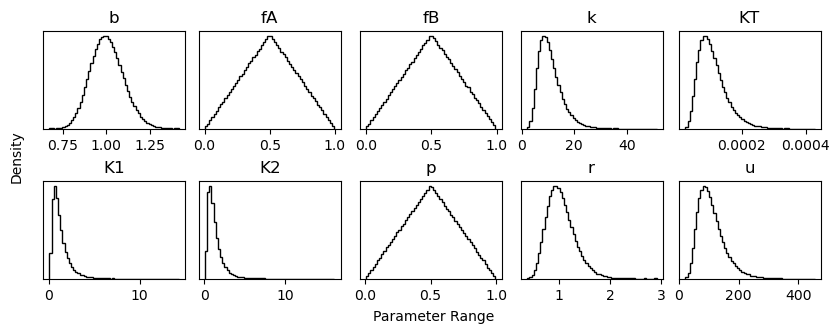

In [4]:
read_in = True
conjugation = True
    
def plot_histograms(param_samples):
    
    fig, axes = plt.subplots(2,5, figsize=(8,3), layout="constrained")
    
    for i, ax in enumerate(axes.flat):
        try:
            ax.hist(param_samples[:,i], bins=60, density=True, histtype='step',color='k')
            ax.set_title('$'+SA_spec['names'][i]+'$')
            ax.set_yticks([])
            ax.yaxis.set_tick_params(labelleft=False)
            
        except IndexError:
            pass
    
    fig.text(0.5, -.05, 'Parameter Range', ha='center')
    fig.text(-0.03, 0.5, 'Density', va='center', rotation='vertical')

    plt.savefig('param_distributions.svg', bbox_inches='tight')
    plt.show()

    
if read_in:
    SA_spec = setup(conjugation)

    with open(f'conjugation_{conjugation}_sample_12.npy', 'rb') as f:
        param_samples = np.load(f)['samples']
        SA_spec.set_samples(np.load(f)['samples'])
        SA_spec.set_results(np.load(f)['results'])
        
    plot_histograms(param_samples)

else:
    SA_spec = setup(conjugation)
    
    samples = 2**12 # default uses 2**12

    SA_spec.sample_sobol(samples, calc_second_order=True)

    param_samples = SA_spec.samples

    plot_histograms(param_samples)
    
    output_samples = np.zeros((np.shape(param_samples)[0], len(SA_spec['outputs'])))

    for index, param_sample in enumerate(tqdm(param_samples)):

        params.update(dict(zip(SA_spec['names'], param_sample)))
        time, densities = integrate(HGT_TOXIN, ICs, params, maximum_time)
        output_samples[index,0:3] = densities[-1,0:3]
        
    SA_spec.set_results(output_samples)

    with open('HGT_TOXIN_new.npy', 'wb') as f:
        np.savez(f, samples=param_samples, results=output_samples)

We can visualise the uncertainty in the steady state abundances by plotting the mean and standard deviation of the sample model outputs.

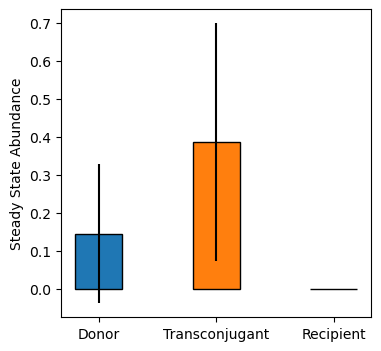

In [5]:
Donor = SA_spec.results[:,0]
Transconjugant = SA_spec.results[:,1]
Recipient = SA_spec.results[:,2]

fig, ax = plt.subplots(1,1, figsize=(4,4))

width = .4

ax.bar(0, np.mean(Donor), width, edgecolor="black", yerr = np.std(Donor))
ax.bar(1, np.mean(Transconjugant), width, edgecolor="black", yerr = np.std(Transconjugant))
ax.bar(2, np.mean(Recipient), width, edgecolor="black", yerr = np.std(Recipient))

ax.set_ylabel('Steady State Abundance')
ax.set_xticks(range(3), SA_spec['outputs'])

plt.savefig(f'output_barchart_conjugation_{conjugation}.svg')

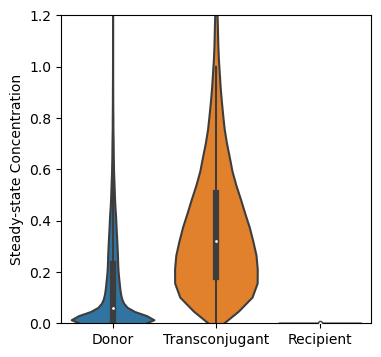

In [6]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

sns.violinplot(data=SA_spec.results, scale='count')

ax.set_xticks(range(3), SA_spec['outputs'])
ax.set_xlim([-.5,2.5])

ax.set_ylabel('Steady-state Concentration')
ax.set_ylim([0,1.2])

plt.savefig(f'violin_conjugation_{conjugation}.svg')

A natural question is which parameters contribute to this variance. We'll let SALib do the work on this by providing various __Sobol indices__. For a given parameter, the first-order Sobol index `S1` indicates the variance in output individually attributable to that parameter. Variance in the output may also arise from interactions between parameters. This __higher-order__ effect is be captured in the total-order Sobol index `ST`.

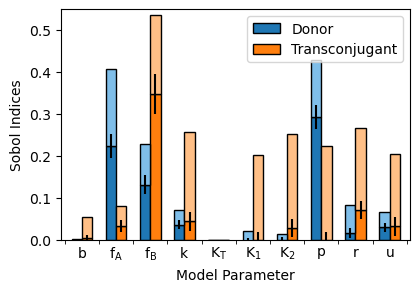

In [7]:
SA_spec.analyze_sobol(print_to_console=False, calc_second_order=True)
indices = SA_spec.analysis

donor_first = indices['Donor']['S1']
trans_first = indices['Transconjugant']['S1']
recip_first = indices['Recipient']['S1']

donor_higher = indices['Donor']['ST'] - indices['Donor']['S1']
trans_higher = indices['Transconjugant']['ST'] - indices['Transconjugant']['S1']
recip_higher = indices['Recipient']['ST'] - indices['Recipient']['S1']

fig, ax = plt.subplots(1,1, figsize=(4.5,3))

width = .3

xlabels = ['$b$', '$f_A$', '$f_B$', '$k$', '$K_T$', '$K_1$', '$K_2$', '$p$', '$r$', '$u$']
x = np.arange(len(xlabels))

if conjugation:
    ax.bar(x-.5*width, donor_first, width, label='Donor', yerr = indices['Donor']['S1_conf'], edgecolor="black")
    ax.bar(x+.5*width, trans_first, width, label='Transconjugant', yerr = indices['Transconjugant']['S1_conf'], edgecolor="black")
#     ax.bar(x+width, recip_first, width, label='Recipient', yerr = indices['Recipient']['S1_conf'], edgecolor="black")

    ax.bar(x-.5*width, donor_higher, width, bottom=donor_first, color='#7fbee9', edgecolor="black")
    ax.bar(x+.5*width, trans_higher, width, bottom=trans_first, color='#ffbf86', edgecolor="black")
#     ax.bar(x+width, recip_higher, width, bottom= recip_first, color='#87de87', edgecolor="black")
    
else:    
    ax.bar(x, np.append(0,recip_first), width, color='#2ca02c', label='Recipient', yerr = np.append(0,indices['Recipient']['S1_conf']), edgecolor="black")
    ax.bar(x, np.append(0,recip_higher), width, bottom=np.append(0, recip_first), color='#87de87', edgecolor="black")


ax.tick_params(axis='x', which='major', length=0)
ax.tick_params(which='minor', length=3)
ax.set_xticks(x, xlabels, minor=False)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

ax.set_xlim([-2*width, 9+2*width])

ax.set_xlabel('Model Parameter')
ax.set_ylabel('Sobol Indices')
ax.set_ylim([0,0.55])

ax.legend(loc='best')

plt.savefig("param_sensitivity.svg")

In [8]:
donor_second = np.matrix(indices['Donor']['S2'])
trans_second = np.matrix(indices['Transconjugant']['S2'])


# print(donor_second.round(decimals=3))
print(np.nansum(donor_second,axis=1))

# print(trans_second.round(decimals=3))
print(np.nansum(trans_second,axis=1))


[[-1.37833269e-02]
 [ 2.64036634e-01]
 [ 9.80427702e-02]
 [-6.95799192e-02]
 [ 4.75766501e-05]
 [ 5.91418663e-03]
 [ 7.39066894e-03]
 [ 6.62424145e-03]
 [ 1.33187716e-02]
 [ 0.00000000e+00]]
[[-4.49904504e-02]
 [ 4.23669688e-02]
 [-1.24904800e-01]
 [-1.06609778e-01]
 [-2.99898560e-05]
 [ 1.31900511e-02]
 [ 3.95648360e-02]
 [ 3.54464816e-02]
 [ 9.48516682e-03]
 [ 0.00000000e+00]]
